# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession, Window
from pyspark.sql.types import StringType, IntegerType
from pyspark.sql.functions import avg, explode, concat, lit, min, max, split, udf, isnull, col, desc

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from datetime import datetime
from time import time

from pyspark.ml.feature import Normalizer, StandardScaler, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, GBTClassifier, RandomForestClassifier, LinearSVC
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [2]:
# create a Spark session
spark = SparkSession \
        .builder \
        .appName("mysparkify") \
        .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
data_path = 'data/mini_sparkify_event_data.json'
df = spark.read.json(data_path)

# See the frame schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [4]:
df.head(2)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9')]

Drop missing userId and sessionId

In [5]:
df = df.dropna(how = 'any', subset = ['userId','sessionId'])
df = df[df.userId != ""]

In [6]:
print("The number of rows in the dataframe is {}".format(df.count()))
print("The number of columns in the dataframe is {}".format(len(df.columns)))

The number of rows in the dataframe is 278154
The number of columns in the dataframe is 18


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

In [7]:
# No of unique users in the data set
df.select("userId").dropDuplicates().count()

225

In [8]:
# No of unique sessions the data iset
df.select("sessionId").dropDuplicates().count()

2312

In [9]:
# User activities
df.select('page').dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [10]:
# add downgrade flag, 1 or 0
is_downgrade = udf(lambda x: int(x=="Submit Downgrade"), IntegerType())
df = df.withColumn("downgrade", is_downgrade("page"))

# add downgrade user flag
df = df.withColumn("user_downgrade", max("downgrade").over(Window.partitionBy("UserId")))

# add churn, 1 or 0
is_churn = udf(lambda x: int(x=="Cancellation Confirmation"), IntegerType())
df = df.withColumn("churn", is_churn("page"))

# add churn user flag
df = df.withColumn("user_churn", max('churn').over(Window.partitionBy('UserId')))

Convert timestamp format

In [11]:
convert_ts = udf(lambda x: datetime.fromtimestamp(x / 1000.0).strftime("%m-%d-%Y %H:%M:%S"))
df = df.withColumn('registration_datetime', convert_ts('registration'))
df = df.withColumn('event_datetime', convert_ts('ts'))

In [12]:
df.head(1)

[Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', downgrade=0, user_downgrade=0, churn=0, user_churn=0, registration_datetime='09-27-2018 02:45:40', event_datetime='10-08-2018 12:58:54')]

In [13]:
df.select(['userId', 'firstName','level', 'registration_datetime' ,'user_churn', 'user_downgrade']).dropDuplicates(['userId']).show(10)
      
      

+------+---------+-----+---------------------+----------+--------------+
|userId|firstName|level|registration_datetime|user_churn|user_downgrade|
+------+---------+-----+---------------------+----------+--------------+
|100010| Darianna| free|  09-27-2018 02:45:40|         0|             0|
|200002|  Dominic| free|  09-06-2018 21:38:26|         0|             0|
|   125|    Mason| free|  08-01-2018 20:58:59|         1|             0|
|   124|   Nicole| paid|  07-22-2018 01:52:15|         0|             0|
|    51|    Ethan| paid|  09-27-2018 20:43:07|         1|             0|
|     7|   Maddox| free|  09-11-2018 12:06:16|         0|             0|
|    15|    Panav| paid|  09-29-2018 16:37:25|         0|             0|
|    54|    Alexi| paid|  07-25-2018 01:37:42|         1|             1|
|   155|   Camila| free|  11-04-2018 22:27:50|         0|             0|
|100014|  Rodrigo| paid|  08-27-2018 17:04:03|         1|             0|
+------+---------+-----+---------------------+-----

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

#### Churn users by genders

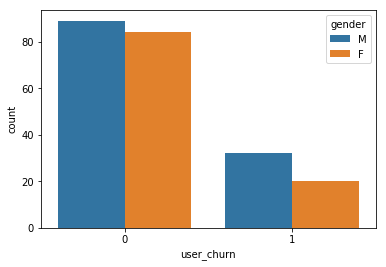

In [14]:
# Plotting a bar plot to show gender distribution between regular and churn users
df_ch_pd = df.drop_duplicates(['userId', 'gender']).groupby(['user_churn', 'gender']).count().sort("user_churn").toPandas()
sns.barplot(x = 'user_churn', y = 'count', data = df_ch_pd, hue = 'gender')

#### At which level do customers churn

As we can observe from the bar plot, male users are more likely to churn when compared to female users.

Text(0.5,1,'Churn usually happens when a customer is using a paid plan')

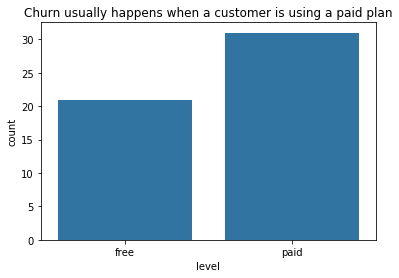

In [15]:
df_level_pd = df.filter('page == "Cancellation Confirmation"').groupby('level').count().toPandas()
sns.barplot(data = df_level_pd, x = 'level', y = 'count', color = sns.color_palette()[0])
plt.title('Churn usually happens when a customer is using a paid plan')

#### Number of songs played per session

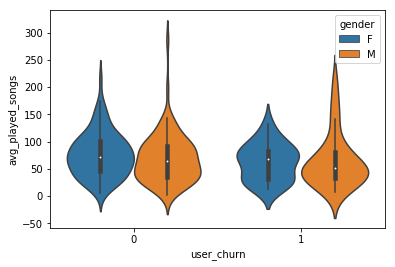

In [16]:
avg_songs_df = df.where('page == "NextSong"').groupby(['user_churn', 'userId', 'sessionId', 'gender']).count()\
    .groupby(['user_churn', 'userId', 'gender']).agg({'count': 'avg'})\
    .withColumnRenamed('avg(count)', 'avg_played_songs').toPandas()

sns.violinplot('user_churn', y = 'avg_played_songs', hue = 'gender', data = avg_songs_df)


We can clearly observe that the churned users clearly played less number of songs per session when compared to users who did not churn

#### Time since registration

In [17]:
df_lt = df.select('userId','registration','ts','churn') \
    .withColumn('lifetime',(df.ts-df.registration)) \
    .groupBy('userId','churn') \
    .agg({'lifetime':'max'}) \
    .withColumnRenamed('max(lifetime)','lifetime') \
    .select('userId', 'churn', (col('lifetime')/1000/3600/24).alias('lifetime')) \
    .toPandas()

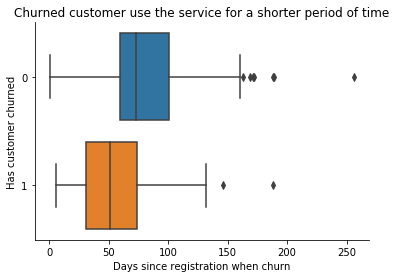

In [18]:
ax = sns.boxplot(data=df_lt, y='churn', x='lifetime', orient='h')
plt.xlabel('Days since registration when churn')
plt.ylabel('Has customer churned')
plt.title('Churned customer use the service for a shorter period of time')
sns.despine(ax=ax);

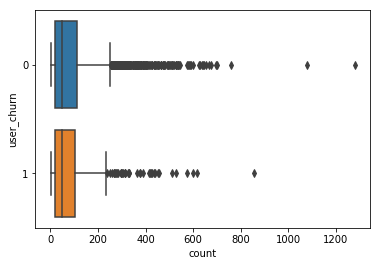

In [19]:
# Let's observe total operations per session between normal and churned users
df_ops = df.groupby("user_churn", "userId", "sessionId").count().toPandas()
sns.boxplot(x = 'count', y = 'user_churn', orient = 'horizontal', data = df_ops)

We can clearly observe that churned users performed far less operations when compared to users who did not churn and male users are more likely to churn

Friends???

In [20]:
df_friends = df.where('page == "Add Friend"').groupby(['user_churn', 'userId', 'gender']).count()\
    .groupby(['user_churn', 'userId', 'gender']).agg({'count': 'avg'})\
    .withColumnRenamed('avg(count)', 'avg_friends').toPandas()

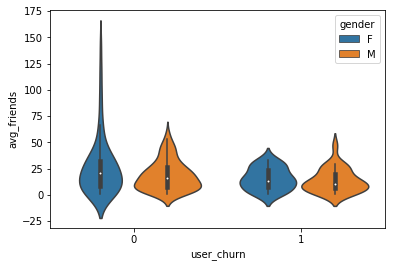

In [21]:
sns.violinplot('user_churn', y = 'avg_friends', hue = 'gender', data = df_friends)

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.


### Create new features
1. Total songs listened
2. Number of thumbs up
3. Number of thumbs up
4. Total time since registration
5. Accumlated services usage time
6. Average songs played per session
7. Number of songs added to playlist
8. Total number of friends

### Relabel categorical variables
1. Gender
2. Downgrade

### Setting target variable
1. Churn

In [22]:
# Total songs listened
total_songs_listened = df.select('userId', 'song').groupBy('userId').count().withColumnRenamed('count', 'total_songs_listened')
total_songs_listened.show(5)

+------+--------------------+
|userId|total_songs_listened|
+------+--------------------+
|100010|                 381|
|200002|                 474|
|   125|                  11|
|    51|                2464|
|   124|                4825|
+------+--------------------+
only showing top 5 rows



In [23]:
# Number of thumbs up
num_thumbs_up = df.select('userId', 'page').where(df.page == 'Thumbs Up').groupBy('userId').count().withColumnRenamed('count', 'num_thumbs_up')
num_thumbs_up.show(5)

+------+-------------+
|userId|num_thumbs_up|
+------+-------------+
|100010|           17|
|200002|           21|
|    51|          100|
|   124|          171|
|     7|            7|
+------+-------------+
only showing top 5 rows



In [24]:
# Number of thumbs up
num_thumbs_down = df.select('userId', 'page').where(df.page == 'Thumbs Down').groupBy('userId').count().withColumnRenamed('count', 'num_thumbs_down')
num_thumbs_down.show(5)

+------+---------------+
|userId|num_thumbs_down|
+------+---------------+
|100010|              5|
|200002|              6|
|    51|             21|
|   124|             41|
|     7|              1|
+------+---------------+
only showing top 5 rows



In [25]:
# Total time since registration
total_lifetime = df.select('userId', 'registration', 'ts').withColumn('total_lifetime', (df.ts - df.registration))\
    .groupBy('userId').agg({'total_lifetime' : 'max'})\
    .withColumnRenamed('max(total_lifetime)', 'total_lifetime')\
    .select('userId', (col('total_lifetime')/1000/3600/24).alias('total_lifetime'))
total_lifetime.show(5)

+------+------------------+
|userId|    total_lifetime|
+------+------------------+
|100010|  55.6436574074074|
|200002| 70.07462962962963|
|   125| 71.31688657407408|
|    51|19.455844907407407|
|   124|131.55591435185184|
+------+------------------+
only showing top 5 rows



In [26]:
# Accumlated services usage time
total_usage_time = df.select("userId", 'length').groupBy('userId').sum().withColumnRenamed('sum(length)', 'Total_usage_time')
total_usage_time.show(5)

+------+------------------+
|userId|  Total_usage_time|
+------+------------------+
|100010| 66940.89735000003|
|200002| 94008.87593999993|
|   125|2089.1131000000005|
|    51| 523275.8428000004|
|   124|1012312.0927899999|
+------+------------------+
only showing top 5 rows



In [27]:
# Average songs played per session
avg_song_played = df.where('page == "NextSong"').groupby(['userId', 'sessionId']).count().groupby(['userId']).agg({'count':'avg'}).withColumnRenamed('avg(count)', 'avg_songs_played')
avg_song_played.show(5)

+------+------------------+
|userId|  avg_songs_played|
+------+------------------+
|100010|39.285714285714285|
|200002|              64.5|
|   125|               8.0|
|    51|             211.1|
|   124|145.67857142857142|
+------+------------------+
only showing top 5 rows



In [28]:
# Number of songs added to playlist
add_to_playlist = df.select('userID','page').where(df.page == 'Add to Playlist').groupBy('userID').count().withColumnRenamed('count', 'add_to_playlist')
add_to_playlist.show(5)

+------+---------------+
|userID|add_to_playlist|
+------+---------------+
|100010|              7|
|200002|              8|
|    51|             52|
|   124|            118|
|     7|              5|
+------+---------------+
only showing top 5 rows



In [29]:
# Total number of friends
total_friends = df.select('userId', 'page').where(df.page == 'Add Friend').groupBy('userId').count().withColumnRenamed('count', 'total_friends')
total_friends.show()

+------+-------------+
|userId|total_friends|
+------+-------------+
|100010|            4|
|200002|            4|
|    51|           28|
|   124|           74|
|     7|            1|
|    54|           33|
|    15|           31|
|   155|           11|
|   132|           41|
|   154|            3|
|100014|            6|
|   101|           29|
|    11|            6|
|   138|           41|
|300017|           63|
|    29|           47|
|    69|           12|
|100021|            7|
|    42|           52|
|   112|            7|
+------+-------------+
only showing top 20 rows



In [30]:
# Lable user gender
gender = df.select('userId', 'gender').dropDuplicates().replace(['F', 'M'], ['0', '1'], 'gender').select('userId', col('gender').cast('int'))
gender.show(5)

+------+------+
|userId|gender|
+------+------+
|    44|     0|
|    46|     0|
|    41|     0|
|    72|     0|
|300023|     0|
+------+------+
only showing top 5 rows



In [31]:
# Label downgrade users
downgrade = df.select('userId', 'user_downgrade').dropDuplicates().select('userId', col('user_downgrade').cast('int'))
downgrade.show(5)

+------+--------------+
|userId|user_downgrade|
+------+--------------+
|100010|             0|
|200002|             0|
|   125|             0|
|   124|             0|
|    51|             0|
+------+--------------+
only showing top 5 rows



In [32]:
# churn label as target variable
churn = df.select('userId', 'user_churn').dropDuplicates()
churn.show(5)

+------+----------+
|userId|user_churn|
+------+----------+
|100010|         0|
|200002|         0|
|   125|         1|
|   124|         0|
|    51|         1|
+------+----------+
only showing top 5 rows



In [33]:
def features_merge(df1, df2):
    """
    This function is used to merge the feature using left join
    
    input: two data frame to be merged
    
    output: merged dataframe
    """
    
    df2 = df2.withColumnRenamed("userId", "userId_dup")
    df = df1.join(df2, df1.userId == df2.userId_dup, "left").drop("userId_dup")
    return df

In [34]:
features_list = [total_songs_listened, num_thumbs_up, num_thumbs_down, total_lifetime, total_usage_time, avg_song_played, add_to_playlist, total_friends, gender, downgrade]

In [68]:
# setting the churn label for our model
target = df.select('userId', col('user_churn').alias('target')).dropDuplicates()
target.show(5)

+------+------+
|userId|target|
+------+------+
|100010|     0|
|200002|     0|
|   125|     1|
|   124|     0|
|    51|     1|
+------+------+
only showing top 5 rows



In [69]:
df_final = target


# use function to merge the features in the list
for feature in features_list:
    df_final = features_merge(df_final, feature)

In [70]:
# sort and view the final dataframe
df_final = df_final.na.fill(0)
df_final = df_final.orderBy('userId', ascending=True)
df_final.head(5)

[Row(userId='10', target=0, total_songs_listened=795, num_thumbs_up=37, num_thumbs_down=4, total_lifetime=51.76265046296297, Total_usage_time=166866.37251000004, avg_songs_played=112.16666666666667, add_to_playlist=9, total_friends=12, gender=1, user_downgrade=0),
 Row(userId='100', target=0, total_songs_listened=3214, num_thumbs_up=148, num_thumbs_down=27, total_lifetime=64.87377314814815, Total_usage_time=672877.856590001, avg_songs_played=78.88235294117646, add_to_playlist=61, total_friends=49, gender=1, user_downgrade=1),
 Row(userId='100001', target=1, total_songs_listened=187, num_thumbs_up=8, num_thumbs_down=2, total_lifetime=44.80021990740741, Total_usage_time=35073.742150000005, avg_songs_played=33.25, add_to_playlist=3, total_friends=2, gender=0, user_downgrade=0),
 Row(userId='100002', target=0, total_songs_listened=218, num_thumbs_up=5, num_thumbs_down=0, total_lifetime=160.47207175925925, Total_usage_time=49559.91809999999, avg_songs_played=48.75, add_to_playlist=5, total_

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### Vectorize all features

In [71]:
features_vectorize = VectorAssembler(inputCols=df_final.columns[2:], outputCol='features_vector')
df_final = features_vectorize.transform(df_final)

In [72]:
df_final.head()

Row(userId='10', target=0, total_songs_listened=795, num_thumbs_up=37, num_thumbs_down=4, total_lifetime=51.76265046296297, Total_usage_time=166866.37251000004, avg_songs_played=112.16666666666667, add_to_playlist=9, total_friends=12, gender=1, user_downgrade=0, features_vector=DenseVector([795.0, 37.0, 4.0, 51.7627, 166866.3725, 112.1667, 9.0, 12.0, 1.0, 0.0]))

### Standardizing all features

In [73]:
scaler = StandardScaler(inputCol = 'features_vector', outputCol = "standard_features", withMean=True, withStd=True)
feature_standardize = scaler.fit(df_final)
df_final = feature_standardize.transform(df_final)

In [74]:
df_final.head()

Row(userId='10', target=0, total_songs_listened=795, num_thumbs_up=37, num_thumbs_down=4, total_lifetime=51.76265046296297, Total_usage_time=166866.37251000004, avg_songs_played=112.16666666666667, add_to_playlist=9, total_friends=12, gender=1, user_downgrade=0, features_vector=DenseVector([795.0, 37.0, 4.0, 51.7627, 166866.3725, 112.1667, 9.0, 12.0, 1.0, 0.0]), standard_features=DenseVector([-0.3319, -0.2868, -0.5594, -0.7457, -0.3112, 0.9709, -0.6114, -0.3405, 0.925, -0.5265]))

In [75]:
df_final.toPandas().to_csv('user_propensity.csv')

In [76]:
data = df_final.select(df_final.target.alias("label"), df_final.standard_features.alias("features"))
data.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[-0.3318762497700...|
|    0|[1.48756135378766...|
|    1|[-0.7891801203625...|
|    0|[-0.7658636401184...|
|    1|[-0.8711638734785...|
+-----+--------------------+
only showing top 5 rows



In [77]:
train, rest = data.randomSplit([0.7, 0.3], seed=42)
validation, test = rest.randomSplit([0.5, 0.5], seed=42)

### Baseline Model

Set an baseline model, with all users labelled as churn = 0, and calculated the model accuracy and f1 score. We shall expect the high score because the churned users are a fairly small subset.

In [78]:
baseline = validation.withColumn('prediction', lit(0.0))

In [79]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Baseline model metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(baseline, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(baseline, {evaluator.metricName: "f1"})))

Baseline model metrics:
Accuracy: 0.6666666666666666
F-1 Score:0.5333333333333333


### Logistic Regression

In [80]:
# initialize classifier
lr = LogisticRegression(maxIter=10)

# set evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

# build paramGrid
paramGrid = ParamGridBuilder().build()

cv_lr = CrossValidator(estimator=lr,
                          evaluator=f1_evaluator, 
                          estimatorParamMaps=paramGrid,
                          numFolds=3)

In [81]:
start = time()
lr_model = cv_lr.fit(train)
end = time()
lr_model.avgMetrics

In [82]:
results_lr = lr_model.transform(validation)

In [83]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Logistic Regression Performance Metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_lr, {evaluator.metricName: "accuracy"})))
print('F-1 Score: {}'.format(evaluator.evaluate(results_lr, {evaluator.metricName: "f1"})))
print('Total training time: {} seconds'.format(end - start))

Logistic Regression Performance Metrics:
Accuracy: 0.6666666666666666
F-1 Score: 0.5333333333333333
Total training time: 591.4150955677032 seconds


### Random Forest

In [84]:
# initialize classifier
rf = RandomForestClassifier()

# set evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

# build paramGrid
paramGrid = ParamGridBuilder().build()

cv_rf = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=f1_evaluator,
                          numFolds=3)

In [85]:
start = time()
rf_model = cv_rf.fit(train)
end = time()
#rf_model.avgMetrics

[0.7973661928680715]

In [86]:
results_rf = rf_model.transform(validation)

In [87]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Random Forest Performance Metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_rf, {evaluator.metricName: "accuracy"})))
print('F-1 Score: {}'.format(evaluator.evaluate(results_rf, {evaluator.metricName: "f1"})))
print('Total training time: {} seconds'.format(end - start))

Random Forest Performance Metrics:
Accuracy: 0.8333333333333334
F-1 Score: 0.8148148148148149
Total training time: 583.6758687496185 seconds


### Gradient Boosted Trees

In [88]:
# initialize classifier
gbt = GBTClassifier(maxIter=10,seed=42)

# set evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

# build paramGrid
paramGrid = ParamGridBuilder().build()

crossval_gbt = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=f1_evaluator,
                          numFolds=3)

In [89]:
start = time()
cvModel_gbt = crossval_gbt.fit(train)
end = time()
#cvModel_gbt.avgMetrics

In [90]:
results_gbt = cvModel_gbt.transform(validation)

In [91]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Gradient Boosted Trees Metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_gbt, {evaluator.metricName: "accuracy"})))
print('F-1 Score: {}'.format(evaluator.evaluate(results_gbt, {evaluator.metricName: "f1"})))
print('Total training time: {} seconds'.format(end - start))

Gradient Boosted Trees Metrics:
Accuracy: 0.8333333333333334
F-1 Score: 0.8148148148148149
Total training time: 995.529360294342 seconds


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.